# Max Cut QAOA - Qiskit

Four Node Maxcut Graph with solutions of "0101" and "1010".

1. "0" is red.
2. "1" is blue.

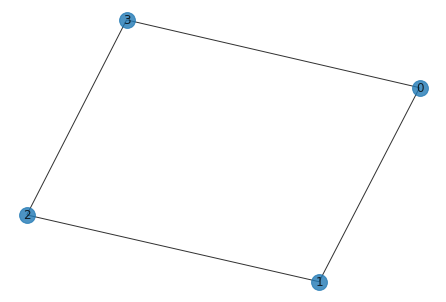

In [1]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=250)

# Maxcut 1 Loop

### **Part A: Without Transpilation**

0. Create QAOA Circuit
1. Initialize Betta and Gamma parameters.
2. Save OpenQASM3 file
3. Execute Circuit on fake backend to get measurement results. 
4. Compute expectation value using the measurement results.
5. Use Classical Optimizer to find new set of parameters using classical optimization algorithm
6. Create new circuit with new set of parameters and then make OpenQASM3 file.


These are the basic steps. The following code has been **slightly** modified from Qiskits website. In the code you will see multiple comments stating,
```python
#STEP
```
to indicate which part of the code corresponds to the steps listed above. 


**Note: For more information about the Qiskit code for the Maxcut problem, click [HERE](https://qiskit.org/textbook/ch-applications/qaoa.html).**




### What does our QAOA circuit for the maxcut problem look like? 
1. What are the parameters that we are updating? **The parameters are Beta and Gamma**

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    qc.barrier()
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
            qc.barrier()

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")

qc_paramNone_untranspiled = create_qaoa_circ(G, [beta, gamma])
qc_paramNone_untranspiled.decompose().draw("mpl").savefig("Images/MaxCut_paramNone_untranspiled_SC.jpg")

### Initializing the circuit with initial values of Beta and Gamma parameters

In [3]:
# STEP 0: Create QAOA Circuit 
# AND 
# STEP 1: Initialize Betta and Gamma parameters using theta.
beta = 1
gamma = 1
qc_param1_untranspiled = create_qaoa_circ(G, [beta, gamma])
qc_param1_untranspiled.decompose().draw("mpl").savefig("Images/MaxCut_param1_untranspiled_SC.jpg")


#STEP 2: Save OpenQASM3 file
from qiskit import qasm3
#print(qasm3.dumps(qc_param1_untranspiled))
# Dump to file
with open("Images/MaxCut_param1_untranspiled_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_param1_untranspiled, fp)

### Defining several functions 

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count



# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):        
        # STEP 0: Create QAOA Circuit 
        # AND 
        # STEP 1: Initialize Betta and Gamma parameters using theta.
        qc_param1_untranspiled = create_qaoa_circ(G, theta) 
        
        
        #(Optional): Can print/save circuit for each iteration. After each iteration the circuit will have updated betta and gamma parameters. 
        #qc_param1_untranspiled.decompose().draw(output='mpl').savefig("Images/MaxCut_param1_untranspiled_SC.jpg")

        
        #(Optional): Can print/save the OpenQASM3 file for each iteration.
        '''
        from qiskit import qasm3
        print(qasm3.dumps(qc_param1_untranspiled))
        # Dump to file
        with open("Images/MaxCut_param1_untranspiled_SC.qasm", 'w+') as fp:
            qasm3.dump(qc_param1_untranspiled, fp)
        '''
        
        #STEP 3: Execute Circuit on fake backend to get measurement results. 
        counts = backend.run(qc_param1_untranspiled, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        
        # STEP 4: Compute expectation value using the measurement results.
        return compute_expectation(counts, G)
    
    return execute_circ

### Using a Classical Optimizer

In [5]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

# STEP 5: Use Classical Optimizer to find new set of parameters using classical optimization algorithm
res = minimize(expectation, 
                      [1.0, 1.0], #STEP 1: Initialize Betta and Gamma parameters.
                      method='COBYLA',
                      options={"maxiter":2})

new_parameters = res.x
print(res, "\n")
print("New Beta: ", res.x[0], "\nNew Gamma: ", res.x[1])

     fun: -2.7578125
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2
  status: 2
 success: False
       x: array([2., 1.]) 

New Beta:  2.0 
New Gamma:  1.0


### Reinitializing the circuit with the updated Beta and Gamma parameters

In [6]:
#STEP 6: Create new circuit with new set of parameters and then make OpenQASM3 file.
qc_param2_untranspiled = create_qaoa_circ(G, new_parameters)
qc_param2_untranspiled.decompose().draw(output='mpl').savefig("Images/MaxCut_param2_untranspiled_SC.jpg")


from qiskit import qasm3
# Qiskit -> OpenQASM3
#print(qasm3.dumps(qc_param2_transpiled3))

# Dump OpenQASM3 to file
with open("Images/MaxCut_param2_untranspiled_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_param2_untranspiled, fp)


### **Part B: With Transpilation**

0. Create QAOA Circuit with specific backend.
1. Transpile with Qiskit
2. Initialize Betta and Gamma parameters.
3. Save OpenQASM3 file
4. Execute Circuit on fake backend to get measurement results. 
5. Compute expectation value using the measurement results.
6. Use Classical Optimizer to find new set of parameters using classical optimization algorithm
7. Create new OpenQASM3 file with new set of parameters.


These are the basic steps. The following code has been **slightly** modified from Qiskits website. In the code you will see multiple comments stating,
```python
#STEP
```
to indicate which part of the code corresponds to the steps listed above. 

**Note: For more information about the Qiskit code for the Maxcut problem, click [HERE](https://qiskit.org/textbook/ch-applications/qaoa.html).**


#### Substep 1) Choose a Backend

In [7]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.providers.fake_provider import FakeMelbourne#, FakeBoeblingen, FakeGuadalupe
from qiskit.transpiler import CouplingMap
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Define a simulated noisy backend
backend = FakeMelbourne()


# Print out basic features of this backend. 
print("---------------------------------Backend Configuration---------------------------------")

config = backend.configuration()
#pp.pprint(config.to_dict())

print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))


print("---------------------------------Backend Properties---------------------------------")
# Print out information about the Properties of the backend.
properties = backend.properties()
#pp.pprint(properties.to_dict())


---------------------------------Backend Configuration---------------------------------
This backend is called fake_melbourne, and is on version 0.0.0. 
It has 14 qubits. 
It does not support OpenPulse programs. 
The basis gates supported on this device are ['u1', 'u2', 'u3', 'cx', 'id']. 
Coupling Map: [[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]]


---------------------------------Backend Properties---------------------------------


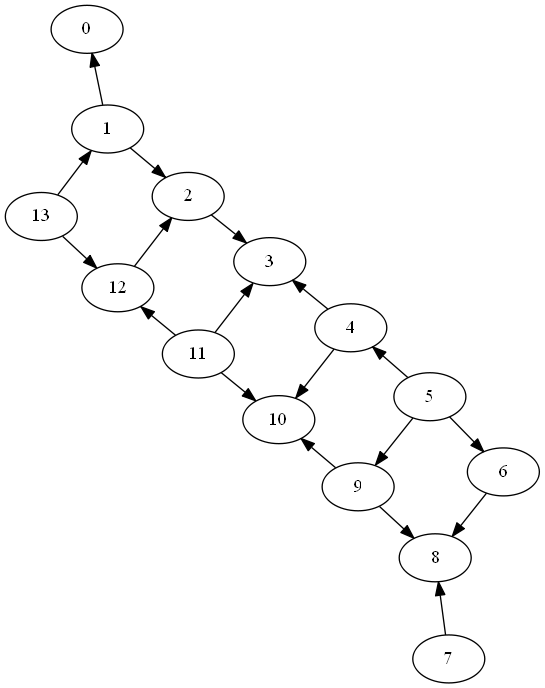

In [8]:
# Print Coupling Map
cm = CouplingMap(config.coupling_map)
cm.draw()

### Initializing the circuit with initial values of Beta and Gamma parameters

In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit import transpile

# ALREADY DEFINED IN PREVIOUS CELL.
# def create_qaoa_circ(G, theta):


# STEP 0: Create QAOA Circuit 
# AND 
# STEP 1: Initialize Betta and Gamma parameters using theta.
beta = 1
gamma = 1
qc_param1_untranspiled = create_qaoa_circ(G, [beta, gamma])
qc_param1_transpiled3 = transpile(qc_param1_untranspiled, backend, optimization_level=3)
qc_param1_transpiled3.decompose().draw("mpl").savefig("Images/MaxCut_param1_transpiled3_SC.jpg")


#STEP 2: Save OpenQASM3 file
from qiskit import qasm3
#print(qasm3.dumps(qc_param1_transpiled3))
# Dump to file
with open("Images/MaxCut_param1_transpiled3_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_param1_transpiled3, fp)

### Defining several functions 

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# ALREADY DEFINED IN PREVIOUS CELL.
#def maxcut_obj(x, G):


# ALREADY DEFINED IN PREVIOUS CELL.
#def compute_expectation(counts, G):

# SLIGHTLY MODIFIED. Creates new circuit with updated parameters, THEN transpiles circuit with fake superconducting backend.
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = FakeMelbourne()
    backend.shots = shots
    
    def execute_circ(theta):        
        # STEP 0: Create QAOA Circuit 
        # AND 
        # STEP 1: Initialize Betta and Gamma parameters using theta.
        qc_param1_untranspiled = create_qaoa_circ(G, theta) 
        qc_param1_transpiled3 = transpile(qc_param1_untranspiled, backend, optimization_level=3)

        
        #(Optional): Can print/save circuit for each iteration. After each iteration the circuit will have updated betta and gamma parameters. 
        #qc_param1_transpiled3.decompose().draw(output='mpl').savefig("Images/MaxCut_param1_transpiled3_SC.jpg")

        
        #(Optional): Can print/save the OpenQASM3 file for each iteration.
        '''
        from qiskit import qasm3
        print(qasm3.dumps(qc_param1_transpiled3))
        # Dump to file
        with open("Images/MaxCut_param1_transpiled3_SC.qasm", 'w+') as fp:
            qasm3.dump(qc_param1_transpiled3, fp)
        '''
        
        #STEP 3: Execute Circuit on fake backend to get measurement results. 
        counts = backend.run(qc_param1_transpiled3, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        
        # STEP 4: Compute expectation value using the measurement results.
        return compute_expectation(counts, G)
    
    return execute_circ

### Using a Classical Optimizer

In [11]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

# STEP 5: Use Classical Optimizer to find new set of parameters using classical optimization algorithm
res = minimize(expectation, 
                      [1.0, 1.0], #STEP 1: Initialize Betta and Gamma parameters.
                      method='COBYLA',
                      options={"maxiter":2})

new_parameters = res.x
print(res, "\n")
print("New Beta: ", res.x[0], "\nNew Gamma: ", res.x[1])

     fun: -2.548828125
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 2
  status: 2
 success: False
       x: array([2., 1.]) 

New Beta:  2.0 
New Gamma:  1.0


### Reinitializing the circuit with the updated Beta and Gamma parameters

In [12]:
#STEP 6: Create new circuit with new set of parameters and then make OpenQASM3 file.
qc_param2_untranspiled = create_qaoa_circ(G, new_parameters)
qc_param2_transpiled3 = transpile(qc_param2_untranspiled, backend, optimization_level=3)
qc_param2_transpiled3.decompose().draw(output='mpl').savefig("Images/MaxCut_param2_transpiled3_SC.jpg")


from qiskit import qasm3
# Qiskit -> OpenQASM3
#print(qasm3.dumps(qc_param2_transpiled3))

# Dump OpenQASM3 to file
with open("Images/MaxCut_param2_transpiled3_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_param2_transpiled3, fp)

# Keeping for reference, but DO NOT use. OLD Way of doing steps.

### Step 0) Create QAOA circuit

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    qc.barrier()
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
            qc.barrier()

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")

qc_paramNone_untranspiled = create_qaoa_circ(G, [beta, gamma])
qc_paramNone_untranspiled.decompose().draw("mpl")#.savefig("Images/MaxCut_paramNone_untranspiled_SC.jpg")

In [ ]:
'''
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(qc_paramNone_untranspiled))
# Dump to file
with open("Images/MaxCut_paramNone_untranspiled_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_paramNone_untranspiled.decompose(), fp)
'''

### Step 1) Transpile with Qiskit
1. Choose A backend
2. Do optimization_level=3 transpilation with the backend.


#### Substep 1) Choose a Backend

In [ ]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.test.mock import FakeMelbourne#, FakeBoeblingen, FakeGuadalupe
from qiskit.transpiler import CouplingMap
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Define a simulated noisy backend
backend = FakeMelbourne()




# Print out basic features of this backend. 
print("---------------------------------Backend Configuration---------------------------------")

config = backend.configuration()
pp.pprint(config.to_dict())

print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))


print("---------------------------------Backend Properties---------------------------------")
# Print out information about the Properties of the backend.
properties = backend.properties()
pp.pprint(properties.to_dict())


In [ ]:
# Print Coupling Map
cm = CouplingMap(config.coupling_map)
cm.draw()

#### Substep 2) Do optimization_level=3 transpilation with the backend.

In [ ]:
from qiskit import transpile
    
qc_paramNone_transpiled3 = transpile(qc_paramNone_untranspiled, backend, optimization_level=3)
qc_paramNone_transpiled3.draw(output='mpl')#.savefig("Images/MaxCut_paramNone_transpiled3_SC.jpg")

### (Skip) Step 2) Initialize Beta and Gamma Parameters

In [ ]:
#qc_basis = create_qaoa_circ(G, [1.0, 1.0])
#qc_basis.decompose().draw("mpl")

### Step 3) Save OpenQASM3 file

In [ ]:
'''
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(qc_paramNone_transpiled3))
# Dump to file
with open("Images/MaxCut_paramNone_transpiled3_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_paramNone_transpiled3, fp)
'''

### Step 4)  Execute Circuit on fake backend to get measurement results. 


In [ ]:
# A function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = FakeMelbourne()
    backend.shots = shots
    
    def execute_circ(theta):
        
        #qc = create_qaoa_circ(G, theta)
        
        
        qc_param1_untranspiled = create_qaoa_circ(G, theta)
        #qc_param1_untranspiled.decompose().draw(output='mpl').savefig("Images/MaxCut_param1_untranspiled_SC.jpg")

        qc_param1_transpiled3 = transpile(qc_param1_untranspiled, backend, optimization_level=3)
        qc_param1_transpiled3.draw(output='mpl').savefig("Images/MaxCut_param1_transpiled3_SC.jpg")
        
        
        from qiskit import qasm3
        print(qasm3.dumps(qc_param1_transpiled3))
        # Dump to file
        with open("Images/MaxCut_param1_transpiled3_SC.qasm", 'w+') as fp:
            qasm3.dump(qc_param1_transpiled3, fp)
        
        
        counts = backend.run(qc_param1_transpiled3, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        
        #counts = backend.run(qc, seed_simulator=10, 
        #                     nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

### Step 5) Compute expectation value using the measurement results.


In [ ]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

### Step 6) Use Classical Optimizer to find new set of parameters using classical optimization algorithm

**Note: For more information about the classical optimizer, click [HERE](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).**



In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=1)

# method = 'COBYLA' is the classical optimizer method
res = minimize(expectation, 
                      [1.0, 2.0], 
                      method='COBYLA',
                      options={"maxiter":1})

new_parameters = res.x
print(res, "\n")
print("New Beta: ", res.x[0], "\nNew Gamma: ", res.x[1])

### Step 7) Create new OpenQASM3 file with new set of parameters.

In [ ]:
qc_param2_untranspiled = create_qaoa_circ(G, new_parameters)

qc_param2_transpiled3 = transpile(qc_param2_untranspiled, backend, optimization_level=3)
qc_param2_transpiled3.decompose().draw(output='mpl').savefig("Images/MaxCut_param2_transpiled3_SC.jpg")

#qc_param2_transpiled3.decompose().draw('mpl')

In [ ]:
# Qiskit Circuit  <-->  .qasm file
from qiskit import qasm3

# Qiskit -> OpenQASM3
# Print
print(qasm3.dumps(qc_param2_transpiled3))
# Dump to file
with open("Images/MaxCut_param2_transpiled3_SC.qasm", 'w+') as fp:
    qasm3.dump(qc_param2_transpiled3, fp)